In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "data.xlsx"

#Create Dataframes from each sheet in data file

staticTare = pd.read_excel(
    FILE,
    sheet_name="StaticTare",
)

noGroundPlate = pd.read_excel(
    FILE,
    sheet_name="NoGroundPlate",
)

dt = pd.read_excel(
    FILE,
    sheet_name="DynamicTare",
)

threeIN = pd.read_excel(
    FILE,
    sheet_name="3in",
)

fiveIN = pd.read_excel(
    FILE,
    sheet_name="5.625in",
)

# Split the 4 runs

# static_tare = df[:][df["Run #"] == "2 w/o Tare"]
# static_tare = static_tare.reset_index(drop=True)
# # Round alpha to match columns
# static_tare["Alpha (deg)"] = static_tare["Alpha (deg)"].round()
# # duplicate missing row
# duplicate = static_tare[static_tare["Alpha (deg)"] == 2.0]
# duplicate_index = duplicate.index.to_list()[0] + 1
# duplicate["Alpha (deg)"] = 6.0
# static_tare_start = static_tare.iloc[:duplicate_index]
# static_tare_end = static_tare.iloc[duplicate_index:]
# static_tare = pd.concat([static_tare_start, duplicate, static_tare_end])
# static_tare = static_tare.reset_index(drop=True)

run_1 = noGroundPlate.copy() #[:][(noGroundPlate["Run #"] == "3 w/o Tare") & (noGroundPlate["Q (psf)"] > 1)]
# run_1 = run_1.reset_index(drop=True)
run_1["AOA"] = run_1["AOA"].round()

run_2 = threeIN.copy() #[:][(df["Run #"] == "4 w/o Tare") & (df["Q (psf)"] > 1)]
# run_2 = run_2.reset_index(drop=True)
run_2["AOA"] = run_2["AOA"].round()

run_3 = fiveIN.copy() #[:][(df["Run #"] == "4 w/o Tare") & (df["Q (psf)"] > 1)]
# run_3 = run_3.reset_index(drop=True)
run_3["AOA"] = run_3["AOA"].round()

# function for getting seconds from hh:mm:ss
def get_sec(datetime: datetime.time):
    """Get seconds from time."""
    h = datetime.hour
    m = datetime.minute
    s = datetime.second
    return h * 3600 + m * 60 + s

How to use tares
1. Subtract static loads
  - $L = L_{run} - L_{st}$
2. Convert to coefficients
  - $C_L = \frac{L}{q_{run} S}$
3. Subtract dynamic tare coefficients
  - $C_L = {C_L}_\text{run} - {C_L}_\text{dyn}$

C:\Users\thegs\AppData\Local\Temp\ipykernel_38224\3573248904.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  run_1["dt"][i] = get_sec(time) - get_sec(run_1["Time"][3])
C:\Users\thegs\AppData\Local\Temp\ipykernel_38224\3573248904.py:27: 

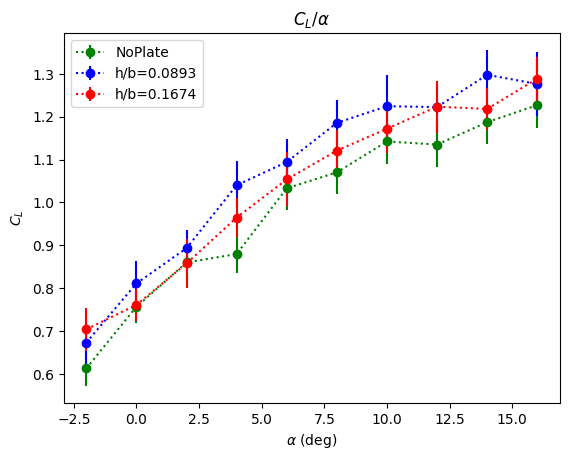

In [3]:
# add non-dimensionalized bits to dynamic tare
dt["lift_coefficient"] = dt["L (lb)"].div(dt["Q (lb/ft.sq)"])
dt["drag_coefficient"] = dt["D (lb)"].div(dt["Q (lb/ft.sq)"])
dt["moment_coefficient"] = dt["PM (lb.ft)"].div(dt["Q (lb/ft.sq)"])

# Find the dynamic tare that matches the target best
q_1_target = 1.5
run_1_dt = dt.iloc[(dt["Q (lb/ft.sq)"] - q_1_target).abs().argsort()[:1]]
run_2_dt = dt.iloc[(dt["Q (lb/ft.sq)"] - q_1_target).abs().argsort()[:1]]
run_3_dt = dt.iloc[(dt["Q (lb/ft.sq)"] - q_1_target).abs().argsort()[:1]]

# wing shape vars
in_to_ft = 12
span = 33.6/12
chord = 5.6 / in_to_ft
# wing is trapezoidal
wing_area = chord * span

# find change in time in seconds for each data point
run_1["dt"] = 0
run_2["dt"] = 0
run_3["dt"] = 0
staticTare["dt"] = 0

i = 0
for time in run_1["Time"]:
    run_1["dt"][i] = get_sec(time) - get_sec(run_1["Time"][3])
    i = i + 1
i = 0
for time in run_2["Time"]:
    run_2["dt"][i] = get_sec(time) - get_sec(run_2["Time"][2])
    i = i + 1
i = 0
for time in run_3["Time"]:
    run_3["dt"][i] = get_sec(time) - get_sec(run_3["Time"][2])
    i = i + 1
i = 0
for time in staticTare["Time"]:
    staticTare["dt"][i] = get_sec(time) - get_sec(staticTare["Time"][0])
    i = i + 1

# find change in lift due to tempurature
dLdt1 = (run_1["L (lb)"][15]-run_1["L (lb)"][1])/(get_sec(run_1["Time"][15])-get_sec(run_1["Time"][1]))
dLdt2 = (run_2["L (lb)"][13]-run_2["L (lb)"][1])/(get_sec(run_2["Time"][13])-get_sec(run_2["Time"][1]))
dLdt3 = (run_3["L (lb)"][13]-run_3["L (lb)"][1])/(get_sec(run_3["Time"][13])-get_sec(run_3["Time"][1]))
dLdtST = (staticTare["L (lb)"][11]-staticTare["L (lb)"][0])/(get_sec(run_3["Time"][11])-get_sec(run_3["Time"][1]))

# apply change in lift due to tempurature
run_1["L (lb)"] = run_1["L (lb)"] - dLdt1 * run_1["dt"]
run_2["L (lb)"] = run_2["L (lb)"] - dLdt1 * run_2["dt"]
run_3["L (lb)"] = run_3["L (lb)"] - dLdt1 * run_3["dt"]
staticTare["L (lb)"] = staticTare["L (lb)"] - dLdtST * staticTare["dt"]

# drop unwanted values
staticTare.drop([0,11], inplace= True, axis=0)
staticTare.reset_index(drop=True, inplace=True)

run_1.drop([0,1,2,3,14,15,16], inplace= True, axis=0)
run_1.reset_index(drop=True, inplace=True)

run_2.drop([0,1,2,14,13], inplace= True, axis=0)
run_2.reset_index(drop=True, inplace=True)

run_3.drop([0,1,2,14,13], inplace= True, axis=0)
run_3.reset_index(drop=True, inplace=True)

# apply static tares
run_1["L (lb)"] = run_1["L (lb)"] - staticTare["L (lb)"]
run_1["D (lb)"] = run_1["D (lb)"] - staticTare["D (lb)"]
run_1["PM (lb.ft)"] = run_1["PM (lb.ft)"] - staticTare["PM (lb.ft)"]

run_2["L (lb)"] = run_2["L (lb)"] - staticTare["L (lb)"]
run_2["D (lb)"] = run_2["D (lb)"] - staticTare["D (lb)"]
run_2["PM (lb.ft)"] = run_2["PM (lb.ft)"] - staticTare["PM (lb.ft)"]

run_3["L (lb)"] = run_3["L (lb)"] - staticTare["L (lb)"]
run_3["D (lb)"] = run_3["D (lb)"] - staticTare["D (lb)"]
run_3["PM (lb.ft)"] = run_3["PM (lb.ft)"] - staticTare["PM (lb.ft)"]

# adjust moment center
dx = 0.625 + .5
dy = 0.22
run_1["PM (lb.ft)"] = (
    run_1["PM (lb.ft)"] + dy * run_1["D (lb)"] - dx * run_1["L (lb)"]
)
run_2["PM (lb.ft)"] = (
    run_2["PM (lb.ft)"] + dy * run_2["D (lb)"] - dx * run_2["L (lb)"]
)
run_3["PM (lb.ft)"] = (
    run_3["PM (lb.ft)"] + dy * run_3["D (lb)"] - dx * run_3["L (lb)"]
)

# run 1 coefficients
run_1["lift_coefficient"] = run_1["L (lb)"].div(run_1["Q (lb/ft.sq)"] * wing_area)
run_1["drag_coefficient"] = run_1["D (lb)"].div(run_1["Q (lb/ft.sq)"] * wing_area)
run_1["moment_coefficient"] = run_1["PM (lb.ft)"].div(run_1["Q (lb/ft.sq)"] * wing_area)
run_1.lift_coefficient = run_1.lift_coefficient - run_1_dt.lift_coefficient.values[0]
run_1.drag_coefficient = run_1.drag_coefficient - run_1_dt.drag_coefficient.values[0]
run_1.moment_coefficient = (
    run_1.moment_coefficient - run_1_dt.moment_coefficient.values[0]
)

# run 2 coefficients
run_2["lift_coefficient"] = run_2["L (lb)"].div(run_2["Q (lb/ft.sq)"] * wing_area)
run_2["drag_coefficient"] = run_2["D (lb)"].div(run_2["Q (lb/ft.sq)"] * wing_area)
run_2["moment_coefficient"] = run_2["PM (lb.ft)"].div(run_2["Q (lb/ft.sq)"] * wing_area)
run_2.lift_coefficient = run_2.lift_coefficient - run_2_dt.lift_coefficient.values[0]
run_2.drag_coefficient = run_2.drag_coefficient - run_2_dt.drag_coefficient.values[0]
run_2.moment_coefficient = (
    run_2.moment_coefficient - run_2_dt.moment_coefficient.values[0]
)

#run 3 coefficients
run_3["lift_coefficient"] = run_3["L (lb)"].div(run_3["Q (lb/ft.sq)"] * wing_area)
run_3["drag_coefficient"] = run_3["D (lb)"].div(run_3["Q (lb/ft.sq)"] * wing_area)
run_3["moment_coefficient"] = run_3["PM (lb.ft)"].div(run_3["Q (lb/ft.sq)"] * wing_area)
run_3.lift_coefficient = run_3.lift_coefficient - run_3_dt.lift_coefficient.values[0]
run_3.drag_coefficient = run_3.drag_coefficient - run_3_dt.drag_coefficient.values[0]
run_3.moment_coefficient = (
    run_3.moment_coefficient - run_3_dt.moment_coefficient.values[0]
)

run_1_sorted = run_1.sort_values(by="AOA")
run_2_sorted = run_2.sort_values(by="AOA")
run_3_sorted = run_3.sort_values(by="AOA")

sample_rate = 200
sample_period = 2
n = sample_rate * sample_period

confidence_value = 1.65 # 90% confidence

run_1_sorted["L_Error"] = confidence_value*run_1_sorted["L Std. Dev. (lb)"]/(n**(1/2))
run_2_sorted["L_Error"] = confidence_value*run_2_sorted["L Std. Dev. (lb)"]/(n**(1/2))
run_3_sorted["L_Error"] = confidence_value*run_3_sorted["L Std. Dev. (lb)"]/(n**(1/2))

run_1_sorted["Q_Error"] = confidence_value*run_1_sorted['Q Std. Dev. (lb/ft.sq)']/(n**(1/2))
run_2_sorted["Q_Error"] = confidence_value*run_2_sorted['Q Std. Dev. (lb/ft.sq)']/(n**(1/2))
run_3_sorted["Q_Error"] = confidence_value*run_3_sorted['Q Std. Dev. (lb/ft.sq)']/(n**(1/2))

run_1_sorted["D_Error"] = confidence_value*run_1_sorted["D Std. Dev. (lb)"]/(n**(1/2))
run_2_sorted["D_Error"] = confidence_value*run_2_sorted["D Std. Dev. (lb)"]/(n**(1/2))
run_3_sorted["D_Error"] = confidence_value*run_3_sorted["D Std. Dev. (lb)"]/(n**(1/2))

run_1_sorted["Pm_Error"] = confidence_value*run_1_sorted["PM Std. Dev. (lb.ft)"]/(n**(1/2))
run_2_sorted["Pm_Error"] = confidence_value*run_2_sorted["PM Std. Dev. (lb.ft)"]/(n**(1/2))
run_3_sorted["Pm_Error"] = confidence_value*run_3_sorted["PM Std. Dev. (lb.ft)"]/(n**(1/2))

dCLdQ1 = -run_1_sorted["L (lb)"]/((run_1_sorted["Q (lb/ft.sq)"]**2)*wing_area)
dCLdQ2 = -run_2_sorted["L (lb)"]/((run_2_sorted["Q (lb/ft.sq)"]**2)*wing_area)
dCLdQ3 = -run_3_sorted["L (lb)"]/((run_3_sorted["Q (lb/ft.sq)"]**2)*wing_area)

dCDdQ1 = -run_1_sorted["D (lb)"]/((run_1_sorted["Q (lb/ft.sq)"]**2)*wing_area)
dCDdQ2 = -run_2_sorted["D (lb)"]/((run_2_sorted["Q (lb/ft.sq)"]**2)*wing_area)
dCDdQ3 = -run_3_sorted["D (lb)"]/((run_3_sorted["Q (lb/ft.sq)"]**2)*wing_area)

dCLdL1 = 1/((run_1_sorted["Q (lb/ft.sq)"])*wing_area)
dCLdL2 = 1/((run_2_sorted["Q (lb/ft.sq)"])*wing_area)
dCLdL3 = 1/((run_3_sorted["Q (lb/ft.sq)"])*wing_area)

dCDdD1 = 1/((run_1_sorted["Q (lb/ft.sq)"])*wing_area)
dCDdD2 = 1/((run_2_sorted["Q (lb/ft.sq)"])*wing_area)
dCDdD3 = 1/((run_3_sorted["Q (lb/ft.sq)"])*wing_area)

dCMdM1 = 1/((run_1_sorted["Q (lb/ft.sq)"])*wing_area)
dCMdM2 = 1/((run_2_sorted["Q (lb/ft.sq)"])*wing_area)
dCMdM3 = 1/((run_3_sorted["Q (lb/ft.sq)"])*wing_area)

run_1_sorted["LUncertainty"] = ((run_1_sorted["L_Error"]*dCLdL1)**2+(run_1_sorted["Q_Error"]*dCLdQ1)**2)**(1/2)
run_2_sorted["LUncertainty"] = ((run_2_sorted["L_Error"]*dCLdL2)**2+(run_2_sorted["Q_Error"]*dCLdQ2)**2)**(1/2)
run_3_sorted["LUncertainty"] = ((run_3_sorted["L_Error"]*dCLdL3)**2+(run_3_sorted["Q_Error"]*dCLdQ3)**2)**(1/2)

run_1_sorted["DUncertainty"] = ((run_1_sorted["D_Error"]*dCDdD1)**2+(run_1_sorted["Q_Error"]*dCDdQ1)**2)**(1/2)
run_2_sorted["DUncertainty"] = ((run_2_sorted["D_Error"]*dCDdD2)**2+(run_2_sorted["Q_Error"]*dCDdQ2)**2)**(1/2)
run_3_sorted["DUncertainty"] = ((run_3_sorted["D_Error"]*dCDdD3)**2+(run_3_sorted["Q_Error"]*dCDdQ3)**2)**(1/2)

run_1_sorted["PmUncertainty"] = ((run_1_sorted["Pm_Error"]*dCMdM1)**2+(run_1_sorted["Q_Error"]*dCDdQ1)**2)**(1/2)
run_2_sorted["PmUncertainty"] = ((run_2_sorted["Pm_Error"]*dCMdM2)**2+(run_2_sorted["Q_Error"]*dCDdQ2)**2)**(1/2)
run_3_sorted["PmUncertainty"] = ((run_3_sorted["Pm_Error"]*dCMdM3)**2+(run_3_sorted["Q_Error"]*dCDdQ3)**2)**(1/2)


fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$C_L$")
ax.set_title("$C_L / \\alpha$")
line_1 = ax.errorbar(run_1_sorted["AOA"], run_1_sorted.lift_coefficient, run_1_sorted["LUncertainty"], fmt= "go:")
line_1.set_label("NoPlate")
line_2 = ax.errorbar(run_2_sorted["AOA"], run_2_sorted.lift_coefficient, run_2_sorted["LUncertainty"], fmt= "bo:")
line_2.set_label("h/b=0.0893")
line_3 = ax.errorbar(run_3_sorted["AOA"], run_3_sorted.lift_coefficient, run_3_sorted["LUncertainty"], fmt= "ro:")
line_3.set_label("h/b=0.1674")
_ = ax.legend()

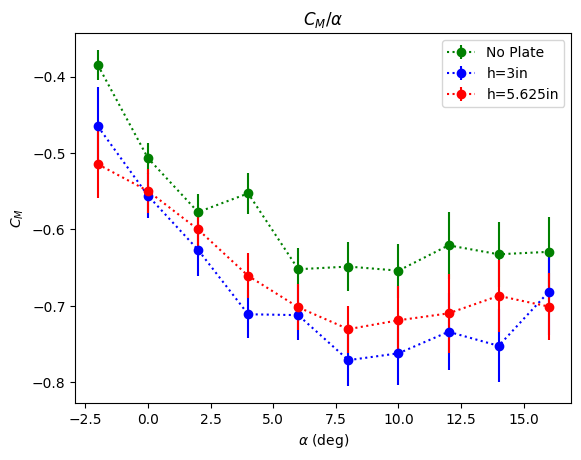

In [4]:
fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$C_M$")
ax.set_title("$C_M / \\alpha$")
line_1 = ax.errorbar(run_1_sorted["AOA"], run_1_sorted.moment_coefficient, run_1_sorted["PmUncertainty"], fmt= "go:")
line_1.set_label("No Plate")
line_2 = ax.errorbar(run_2_sorted["AOA"], run_2_sorted.moment_coefficient, run_2_sorted["PmUncertainty"], fmt= "bo:")
line_2.set_label("h=3in")
line_3 = ax.errorbar(run_2_sorted["AOA"], run_3_sorted.moment_coefficient, run_3_sorted["PmUncertainty"], fmt= "ro:")
line_3.set_label("h=5.625in")
_ =  ax.legend()

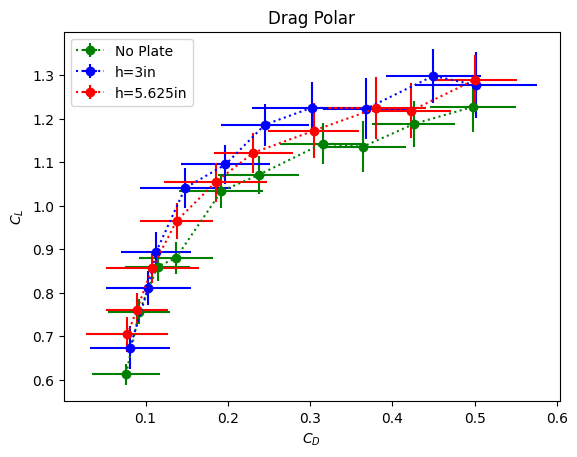

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel("$C_D$")
ax.set_ylabel("$C_L$")
ax.set_title("Drag Polar")
line_1 = ax.errorbar(run_1_sorted.drag_coefficient, run_1_sorted.lift_coefficient, run_1_sorted["DUncertainty"], run_1_sorted["LUncertainty"] ,fmt= "go:")
line_1.set_label("No Plate")
line_2 = ax.errorbar(run_2_sorted.drag_coefficient, run_2_sorted.lift_coefficient, run_2_sorted["DUncertainty"], run_2_sorted["LUncertainty"], fmt="bo:")
line_2.set_label("h=3in")
line_3 = ax.errorbar(run_3_sorted.drag_coefficient, run_3_sorted.lift_coefficient, run_3_sorted["DUncertainty"], run_3_sorted["LUncertainty"], fmt="ro:")
line_3.set_label("h=5.625in")
_ =  ax.legend()

In [6]:
hide_cols = [
    # "Run #",
    # "Point #",
    "Time",
    # "Beta (deg)",
    # "Phi (deg)",
    # "Q (psf)",
    # "Side Force (lb)",
    # "Yaw (lb-ft)",
    # "Roll (lb-ft)",
    # "Lift StDev (lb)",
    # "Drag StDev (lb)",
    # "Side Force StDev (lb)",
    # "Pitch StDev (lb-ft)",
    # "Yaw StDev (lb-ft)",
    # "Roll StDev (lb-ft)",
    # "Q StDev (psf)",
    # "Alpha StDev (deg)",
    # "Beta StDev (deg)",
    # "x offset (in)",
    # "y offset (in)",
    # "z offset (in)",
    # "Ref Area (sqf)",
    # "Ref Length (ft)",
    # "Re",
    "COMMENTS",
    # "Z (deg)",
    # "Y (deg)",
    # "X (deg)",
    # "Calibration",
    "AOA Std. Dev.",
    "L Std. Dev. (lb)",
    "D Std. Dev. (lb)",
    "PM Std. Dev. (lb.ft)",
    "Q Std. Dev. (lb/ft.sq)",
    "Q (lb/ft.sq)",
    "dt",
]
run_1.style.hide(
    hide_cols,
    axis="columns",
).relabel_index(
    [
        "AOA (lb)",
        "L (lb)",
        "D (lb)",
        "Pitching Moment",
        "Lift Coefficient",
        "Drag Coefficient",
        "Moment Coefficient",
    ],
    axis="columns",
).format(
    {
        "Alpha (deg)": "{:.0f}",
        "Lift (lb)": "{:.3g}",
        "Drag (lb)": "{:.3g}",
        "Pitch (lb-ft)": "{:.3g}",
    }
)

,AOA (lb),L (lb),D (lb),Pitching Moment,Lift Coefficient,Drag Coefficient,Moment Coefficient
0,-2.000000,1.307238,0.243700,-0.865629,0.613175,0.076367,-0.384680
1,-0.000000,1.593469,0.273700,-1.112938,0.756762,0.092300,-0.506557
2,2.000000,1.926129,0.341500,-1.342065,0.860007,0.114696,-0.577261
3,4.000000,1.847489,0.367800,-1.205109,0.879807,0.136986,-0.552717
4,6.000000,2.189284,0.489000,-1.426665,1.033114,0.192161,-0.652070
5,8.000000,2.434526,0.628900,-1.522284,1.070308,0.237274,-0.648552
6,10.000000,2.424875,0.754100,-1.430682,1.142386,0.315120,-0.653934
7,12.000000,2.423912,0.864900,-1.367423,1.135167,0.364095,-0.620772
8,14.000000,2.460515,0.968700,-1.350865,1.187271,0.425819,-0.632480
9,16.000000,2.512864,1.107500,-1.327422,1.227179,0.498419,-0.629273


In [7]:

run_2.style.hide(
    hide_cols,
    axis="columns",
).relabel_index(
    [
        "Alpha (deg)",
        "Lift (lb)",
        "Drag (lb)",
        "Pitch (lb-ft)",
        "Lift Coefficient",
        "Drag Coefficient",
        "Moment Coefficient",
    ],
    axis="columns",
).format(
    {
        "Alpha (deg)": "{:.0f}",
        "Lift (lb)": "{:.3g}",
        "Drag (lb)": "{:.3g}",
        "Pitch (lb-ft)": "{:.3g}",
    }
)

,Alpha (deg),Lift (lb),Drag (lb),Pitch (lb-ft),Lift Coefficient,Drag Coefficient,Moment Coefficient
0,-2.000000,1.207731,0.212900,-0.874359,0.673196,0.080908,-0.464928
1,0.000000,1.493127,0.259400,-1.063700,0.811217,0.103214,-0.555669
2,2.000000,1.693521,0.285100,-1.230490,0.893394,0.112777,-0.626637
3,4.000000,1.790613,0.320000,-1.261839,1.040338,0.148112,-0.711019
4,6.000000,2.110407,0.454300,-1.414762,1.094415,0.197138,-0.712170
5,8.000000,2.396322,0.573700,-1.601748,1.185778,0.245006,-0.771134
6,10.000000,2.065902,0.575900,-1.321141,1.224582,0.301795,-0.762167
7,12.000000,2.377408,0.795100,-1.467162,1.222606,0.368329,-0.733947
8,14.000000,2.643111,1.000200,-1.573256,1.297922,0.449820,-0.752391
9,16.000000,2.450828,1.044000,-1.345902,1.276491,0.501580,-0.681645


In [8]:
LArray1 = []
for L in run_1_sorted["lift_coefficient"]:
    LArray1.append(L)
LArray1 = np.asarray(LArray1)
AOAArray1 = []
for AOA in run_1_sorted["AOA"]:
    AOAArray1.append([AOA, 1])
AOAArray1 = np.asarray(AOAArray1)
DArray1 = []
for D in run_1_sorted["drag_coefficient"]:
    DArray1.append([D, 1])
DArray1 = np.asarray(DArray1)

regression1 = np.matmul(np.linalg.inv(np.matmul(AOAArray1.transpose(), AOAArray1)), np.matmul(AOAArray1.transpose(), LArray1))

LArray2 = []
for L in run_2_sorted["lift_coefficient"]:
    LArray2.append(L)
LArray2 = np.asarray(LArray2)
AOAArray2 = []
for AOA in run_2_sorted["AOA"]:
    AOAArray2.append([AOA, 1])
AOAArray2 = np.asarray(AOAArray2)

regression2 = np.matmul(np.linalg.inv(np.matmul(AOAArray2.transpose(), AOAArray2)), np.matmul(AOAArray2.transpose(), LArray2))

LArray3 = []
for L in run_3_sorted["lift_coefficient"]:
    LArray3.append(L)
LArray3 = np.asarray(LArray3)
AOAArray3 = []
for AOA in run_3_sorted["AOA"]:
    AOAArray3.append([AOA, 1])
AOAArray3 = np.asarray(AOAArray3)

regression3 = np.matmul(np.linalg.inv(np.matmul(AOAArray3.transpose(), AOAArray3)), np.matmul(AOAArray3.transpose(), LArray3))

avgUL1 = run_1_sorted["LUncertainty"].sum()/run_1_sorted["L (lb)"].count()
avgUL2 = run_2_sorted["LUncertainty"].sum()/run_2_sorted["L (lb)"].count()
avgUL3 = run_3_sorted["LUncertainty"].sum()/run_3_sorted["L (lb)"].count()

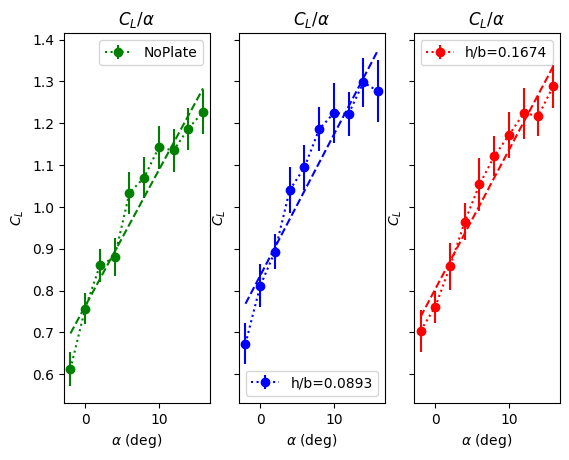

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True)
ax1.set_xlabel("$\\alpha$ (deg)")
ax1.set_ylabel("$C_L$")
ax1.set_title("$C_L / \\alpha$")
line_1 = ax1.errorbar(run_1_sorted["AOA"], run_1_sorted.lift_coefficient, run_1_sorted["LUncertainty"], fmt= "go:")
line_1.set_label("NoPlate")
line_2 = ax1.plot(run_1_sorted["AOA"], regression1[0]*run_1_sorted["AOA"] + regression1[1], color= 'green', linestyle='--')
_ =  ax1.legend()

ax2.set_xlabel("$\\alpha$ (deg)")
ax2.set_ylabel("$C_L$")
ax2.set_title("$C_L / \\alpha$")
line_1 = ax2.errorbar(run_2_sorted["AOA"], run_2_sorted.lift_coefficient, run_2_sorted["LUncertainty"], fmt= "bo:")
line_1.set_label("h/b=0.0893")
line_2 = ax2.plot(run_2_sorted["AOA"], regression2[0]*run_2_sorted["AOA"] + regression2[1], color= 'blue', linestyle='--')
_ =  ax2.legend()

ax3.set_xlabel("$\\alpha$ (deg)")
ax3.set_ylabel("$C_L$")
ax3.set_title("$C_L / \\alpha$")
line_1 = ax3.errorbar(run_3_sorted["AOA"], run_3_sorted.lift_coefficient, run_3_sorted["LUncertainty"], fmt= "ro:")
line_1.set_label("h/b=0.1674")
line_2 = ax3.plot(run_3_sorted["AOA"], regression3[0]*run_3_sorted["AOA"] + regression3[1], color= 'red', linestyle='--')
_ =  ax3.legend()

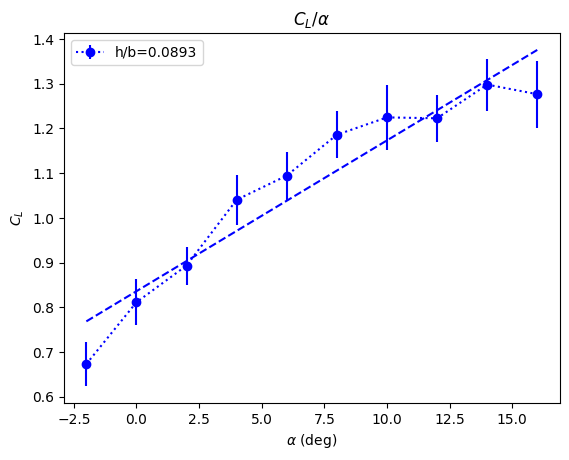

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$C_L$")
ax.set_title("$C_L / \\alpha$")
line_1 = ax.errorbar(run_2_sorted["AOA"], run_2_sorted.lift_coefficient, run_2_sorted["LUncertainty"], fmt= "bo:")
line_1.set_label("h/b=0.0893")
line_2 = ax.plot(run_2_sorted["AOA"], regression2[0]*run_2_sorted["AOA"] + regression2[1], color= 'blue', linestyle='--')
_ =  ax.legend()

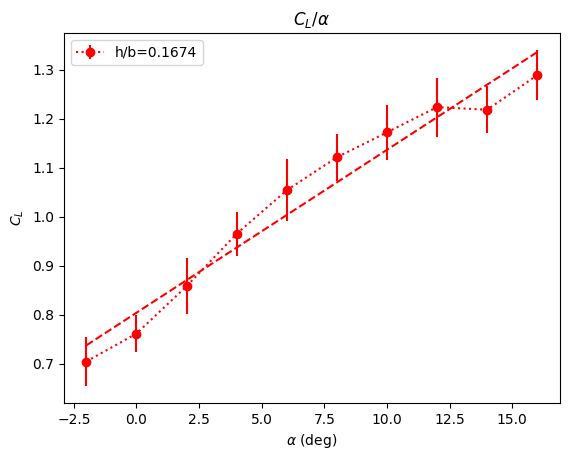

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$C_L$")
ax.set_title("$C_L / \\alpha$")
line_1 = ax.errorbar(run_3_sorted["AOA"], run_3_sorted.lift_coefficient, run_3_sorted["LUncertainty"], fmt= "ro:")
line_1.set_label("h/b=0.1674")
line_2 = ax.plot(run_3_sorted["AOA"], regression3[0]*run_3_sorted["AOA"] + regression3[1], color= 'red', linestyle='--')
_ =  ax.legend()

In [ ]:
finalTable = pd.DataFrame()

finalTable["h/b"] = ["N/A", "0.0893", "0.1674"]
finalTable["Lift Curve Slope"] = [regression1[0], regression2[0], regression3[0]]
finalTable["Lift Curve y-Intercept"] = [f'{regression1[1]:.4f}\u00B1 {avgUL1:.4f}', f'{regression2[1]:.4f}\u00B1 {avgUL2:.4f}', f'{regression3[1]:.4f}\u00B1 {avgUL3:.4f}']
# finalTable["\u00B1"] = [avgUL1,avgUL2,avgUL3]
finalTable["\u0394C_L"] = [0, regression2[1] - regression1[1], regression3[1] - regression1[1]]
finalTable["\u0394\u0025"] = [0, ((regression2[0] - regression1[0])/regression1[0])*100, ((regression3[0] - regression1[0])/regression1[0])*100]
# finalTable["Slope/Uncertainty (%)"] = [(regression1[0]/avgUL1)*100, (regression2[0]/avgUL2)*100, (regression3[0]/avgUL3)*100]


hide_cols = []
finalTable.style.hide(
    hide_cols,
    axis="columns",
)

,h/b,Lift Curve Slope,Lift Curve y-Intercept,ΔC_L,Δ%
0,N/A,0.032546,0.7627± 0.0470,0.000000,0.000000
1,0.0893,0.033717,0.8360± 0.0563,0.073280,3.597730
2,0.1674,0.033271,0.8037± 0.0516,0.040964,2.225063


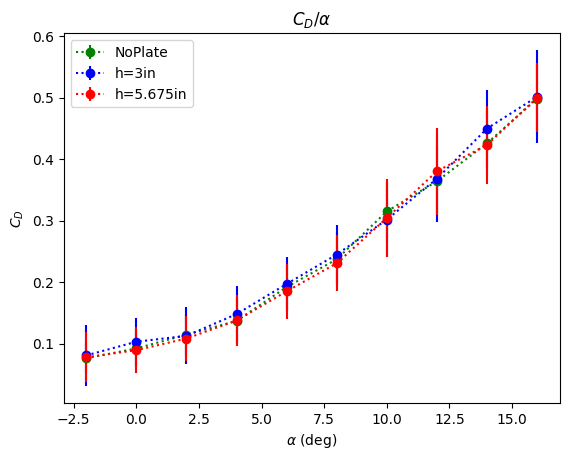

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$C_D$")
ax.set_title("$C_D / \\alpha$")
line_1 = ax.errorbar(run_1_sorted["AOA"], run_1_sorted.drag_coefficient, run_1_sorted["DUncertainty"], fmt= "go:")
line_1.set_label("NoPlate")
line_2 = ax.errorbar(run_2_sorted["AOA"], run_2_sorted.drag_coefficient, run_2_sorted["DUncertainty"], fmt= "bo:")
line_2.set_label("h=3in")
line_3 = ax.errorbar(run_3_sorted["AOA"], run_3_sorted.drag_coefficient, run_3_sorted["DUncertainty"], fmt= "ro:")
line_3.set_label("h=5.675in")
_ = ax.legend()

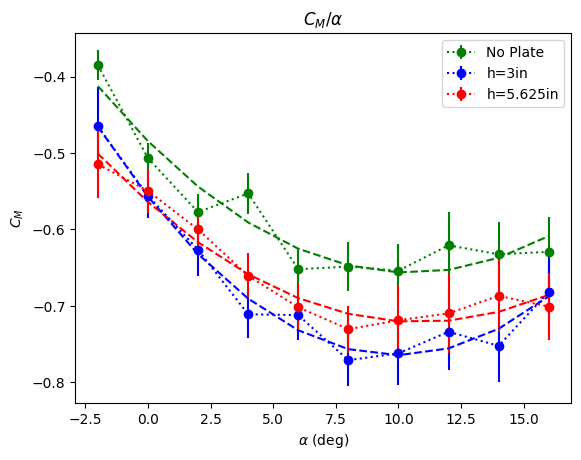

In [ ]:
CMArray1 = []
for CM in run_1_sorted["moment_coefficient"]:
    CMArray1.append(CM)
CMArray1 = np.asarray(CMArray1)
AOAArray1 = []
for AOA in run_1_sorted["AOA"]:
    AOAArray1.append([AOA**2, AOA, 1])
AOAArray1 = np.asarray(AOAArray1)

regression4 = np.matmul(np.linalg.inv(np.matmul(AOAArray1.transpose(), AOAArray1)), np.matmul(AOAArray1.transpose(), CMArray1))

coefficients = np.polyfit(run_1_sorted["AOA"], run_1_sorted["moment_coefficient"], 2)
coefficients2 = np.polyfit(run_2_sorted["AOA"], run_2_sorted["moment_coefficient"], 2)
coefficients3 = np.polyfit(run_3_sorted["AOA"], run_3_sorted["moment_coefficient"], 2)

LArray2 = []
for L in run_2_sorted["lift_coefficient"]:
    LArray2.append(L)
LArray2 = np.asarray(LArray2)
AOAArray2 = []
for AOA in run_2_sorted["AOA"]:
    AOAArray2.append([AOA, 1])
AOAArray2 = np.asarray(AOAArray2)

regression2 = np.matmul(np.linalg.inv(np.matmul(AOAArray2.transpose(), AOAArray2)), np.matmul(AOAArray2.transpose(), LArray2))

LArray3 = []
for L in run_3_sorted["lift_coefficient"]:
    LArray3.append(L)
LArray3 = np.asarray(LArray3)
AOAArray3 = []
for AOA in run_3_sorted["AOA"]:
    AOAArray3.append([AOA, 1])
AOAArray3 = np.asarray(AOAArray3)

regression3 = np.matmul(np.linalg.inv(np.matmul(AOAArray3.transpose(), AOAArray3)), np.matmul(AOAArray3.transpose(), LArray3))

fit1 = coefficients[0]*run_1_sorted["AOA"]**2 + coefficients[1]*run_1_sorted["AOA"] + coefficients[2]
fit2 = coefficients2[0]*run_2_sorted["AOA"]**2 + coefficients2[1]*run_2_sorted["AOA"] + coefficients2[2]
fit3 = coefficients3[0]*run_3_sorted["AOA"]**2 + coefficients3[1]*run_3_sorted["AOA"] + coefficients3[2]

fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$C_M$")
ax.set_title("$C_M / \\alpha$")
line_1 = ax.errorbar(run_1_sorted["AOA"], run_1_sorted.moment_coefficient, run_1_sorted["PmUncertainty"], fmt= "go:")
line_1.set_label("No Plate")
line_2 = ax.errorbar(run_2_sorted["AOA"], run_2_sorted.moment_coefficient, run_2_sorted["PmUncertainty"], fmt= "bo:")
line_2.set_label("h=3in")
line_3 = ax.errorbar(run_2_sorted["AOA"], run_3_sorted.moment_coefficient, run_3_sorted["PmUncertainty"], fmt= "ro:")
line_3.set_label("h=5.625in")
line_4 = ax.plot(run_1_sorted["AOA"], fit1, color="g", linestyle="--")
line_5 = ax.plot(run_2_sorted["AOA"], fit2, color="b", linestyle="--")
line_6 = ax.plot(run_3_sorted["AOA"], fit3, color="r", linestyle="--")
_ =  ax.legend()

In [ ]:
avgUCM1 = run_1_sorted["PmUncertainty"].sum()/run_1_sorted["L (lb)"].count()
avgUCM2 = run_2_sorted["PmUncertainty"].sum()/run_2_sorted["L (lb)"].count()
avgUCM3 = run_3_sorted["PmUncertainty"].sum()/run_3_sorted["L (lb)"].count()


finalTable = pd.DataFrame()

finalTable["h/b"] = ["N/A", "0.0893", "0.1674"]
finalTable["Moment Curve Slope"] = [coefficients[1], coefficients2[1], coefficients3[1]]
finalTable["Moment y-Intercept"] = [f'{coefficients[2]:.4f}\u00B1 {avgUCM1:.4f}', f'{coefficients2[2]:.4f}\u00B1 {avgUCM2:.4f}', f'{coefficients3[2]:.4f}\u00B1 {avgUCM3:.4f}']
# finalTable["\u00B1"] = [avgUL1,avgUL2,avgUL3]
finalTable["\u0394C_M"] = [0, coefficients2[2] - coefficients[2], coefficients3[2] - coefficients[2]]
finalTable["\u0394\u0025"] = [0, ((coefficients2[2] - coefficients[2])/coefficients[2])*100, ((coefficients3[2] - coefficients[2])/coefficients[2])*100]
# finalTable["Slope/Uncertainty (%)"] = [(regression1[0]/avgUL1)*100, (regression2[0]/avgUL2)*100, (regression3[0]/avgUL3)*100]


hide_cols = []
finalTable.style.hide(
    hide_cols,
    axis="columns",
)

,h/b,Moment Curve Slope,Moment y-Intercept,ΔC_M,Δ%
0,N/A,-0.032901,-0.4843± 0.0319,0.000000,0.000000
1,0.0893,-0.041756,-0.5571± 0.0410,-0.072773,15.025632
2,0.1674,-0.029003,-0.5640± 0.0376,-0.079711,16.458254
